# Fraud Detection
## Ubisoft home assignemenet
### Arnaud Baumann

#### Some statistics about the dataset

We will first show some statistics about the dataset

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.tree import DecisionTreeClassifier
from assembleAdaboost import AssembleAdaBoost
import numpy as np
from utils import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# First read the csv with pandas and transform it to a dataframe
df = pd.read_csv("mle_fraud_test.csv", sep=";")
df.describe()

,order_id,user_id,amount,total_amount_14days,email_handle_length,email_handle_dst_char,total_nb_orders_player,player_seniority,total_nb_play_sessions,geographic_distance_risk
count,351608.000000,3.516080e+05,351608.000000,351608.000000,351608.000000,351608.000000,351608.000000,351608.000000,351608.000000,351608.000000
mean,175804.500000,1.815211e+09,19.891322,7.640486,11.215689,8.608701,447.575428,851.906891,162.610305,0.139209
std,101500.631062,1.389552e+09,5.000679,11.414277,3.057254,2.294192,3300.715461,810.101134,209.447766,0.346165
min,1.000000,4.309400e+04,15.380593,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,87902.750000,5.126803e+08,16.564917,0.000000,9.000000,7.000000,4.000000,240.000000,23.000000,0.000000
50%,175804.500000,1.383492e+09,18.022250,0.000000,11.000000,8.000000,12.000000,610.000000,86.000000,0.000000
75%,263706.250000,3.135267e+09,21.038054,17.936250,13.000000,10.000000,34.000000,1245.000000,220.000000,0.000000
max,351608.000000,4.114552e+09,49.864014,189.868357,41.000000,20.000000,41122.000000,6322.000000,3503.000000,1.000000


Let's try to visualize the data with a TSNE. We sample `n_samples = 300` from each class and feed it to a TSNE and plot it


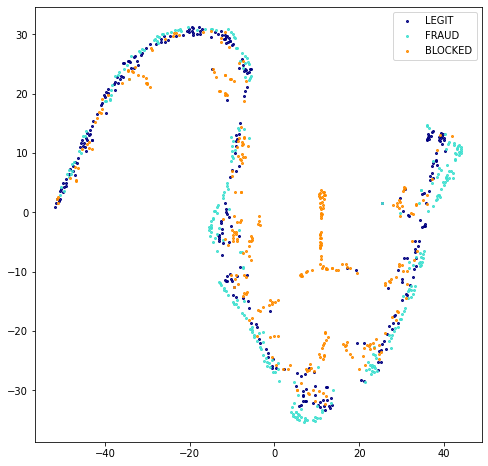

In [2]:
n_samples = 300
legit_df = df[df["transaction_status"]=="LEGIT"].sample(n=n_samples)
fraud_df = df[df["transaction_status"]=="FRAUD"].sample(n=n_samples)
blocked_df = df[df["transaction_status"]=="BLOCKED"].sample(n=n_samples)

X_legit = get_df_features(legit_df)
X_fraud= get_df_features(fraud_df)
X_blocked = get_df_features(blocked_df)

n_components = 2
pca = TSNE(n_components=n_components)
X_pca = pca.fit_transform(np.concatenate([X_legit, X_fraud, X_blocked]))

plt.figure(figsize=(8, 8))
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], ['LEGIT', 'FRAUD', 'BLOCKED']):
    plt.scatter(X_pca[i*n_samples:(i+1)*n_samples,0], X_pca[i*n_samples:(i+1)*n_samples,1], s=1,
                color=color, lw=2, label=target_name)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()

### Dataset imbalance

Datasets for fraud detection are usually very unbalanced, as the majority of samples are valid
(LEGIT in our case). Here we have an additionnal third class named 'BLOCKED' meaning that the existing fraud
management tool has stopped the transaction and we do not have a final label for it. We refer in this notebook
to data with 'BLOCKED' label with variables containing 'blocked'

In [2]:
num_legits = len(df[df["transaction_status"]=="LEGIT"])
num_blocked = len(df[df["transaction_status"]=="BLOCKED"])
num_frauds = len(df[df["transaction_status"]=="FRAUD"])
num_payments = len(df["transaction_status"])
print("Number of legit payments: {} ouf of {} ({:.4f}%)".format( num_legits, num_payments, num_legits/num_payments))
print("Number of blocked payments: {} ouf of {} ({:.4f}%)".format( num_blocked, num_payments, num_blocked/num_payments))
print("Number of fraud payments: {} ouf of {} ({:.4f}%)".format( num_frauds, num_payments, num_frauds/num_payments))


Number of legit payments: 287653 ouf of 351608 (0.8181%)
Number of blocked payments: 61287 ouf of 351608 (0.1743%)
Number of fraud payments: 2668 ouf of 351608 (0.0076%)


# ASSEMBLE.Adaboost algorithm


The ASSEMBLE.Adaboost is implemented in the file assembleAdaBoost as a class named AssembleAdaBoost. <b>(Question 1) </b>

### Answer to question 2:


Starting model fitting...
Done. doing prediction...
precision: FRAUD: 0.8805  LEGIT: 0.9965
recall:    FRAUD: 0.6262  LEGIT: 0.9992
fscore:    FRAUD: 0.7319  LEGIT: 0.9979


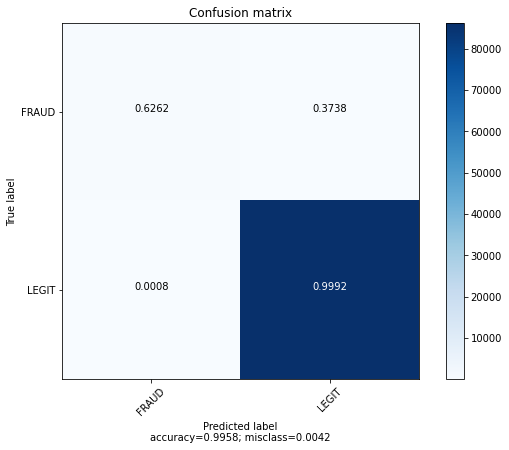

In [32]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

not_blocked_df = df[df["transaction_status"]!="BLOCKED"]
blocked_df = df[df["transaction_status"]=="BLOCKED"]

X_blocked = get_df_features(blocked_df)
X_labeled = get_df_features(not_blocked_df)

y_labeled = get_df_labels(not_blocked_df)
y_labeled = np.array([1 if elem=="LEGIT" else -1 for elem in y_labeled])

X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, stratify=y_labeled, test_size=0.30, shuffle=True)
X_train_blocked = X_blocked
y_train_blocked= get_initial_blocked_labels(X_train, y_train, X_blocked)


print("Starting model fitting...")
clf = AssembleAdaBoost(n_estimators=50)
clf.fit(X_train, X_train_blocked,y_train, y_train_blocked)
print("Done. doing prediction...")
y_pred = clf.predict(X_test)

# Save the fitted model with pickle
file = open('assemble_adaboost_model.pkl', 'wb')
pickle.dump(clf, file)
file.close()

# Print metrcis and the confusion matrix
print_metrics(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ["FRAUD", "LEGIT"])

### Assemble Adaboost benchmark

To see if the algorithm performs well, we can compare it to a similar model, Adaboost. To do so, we use sklearn's
AdaBoostClassifier class and perform 4-fold classification on the dataset for both classifiers.


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix

not_blocked_df = df[df["transaction_status"]!="BLOCKED"]
blocked_df = df[df["transaction_status"]=="BLOCKED"]

X_blocked = get_df_features(blocked_df)
X_labeled = get_df_features(not_blocked_df)

y_labeled = get_df_labels(not_blocked_df)
y_labeled = np.array([1 if elem=="LEGIT" else -1 for elem in y_labeled])

skf = StratifiedKFold(n_splits=4, shuffle=True)
skf.get_n_splits(X_labeled, y_labeled)
print(skf)

for idx, (train_index, test_index) in enumerate(skf.split(X_labeled, y_labeled)):
    print("\ncurrent k-fold:", idx+1)

    X_train_labeled, X_test = X_labeled[train_index], X_labeled[test_index]
    y_train_labeled, y_test= y_labeled[train_index], y_labeled[test_index]

    X_train_blocked = X_blocked
    y_train_blocked= get_initial_blocked_labels(X_train_labeled, y_train_labeled, X_blocked)
    print("\nASSEMBLE Adaboost classification metrics:")
    clf = AssembleAdaBoost(n_estimators=50)
    clf.fit(X_train_labeled, X_train_blocked,y_train_labeled, y_train_blocked)
    y_pred = clf.predict(X_test)
    print_metrics(y_test, y_pred)

    print("\nAdaboost classification metrics:")
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2),algorithm='SAMME')
    clf.fit(X_train_labeled, y_train_labeled)
    y_pred = clf.predict(X_test)
    print_metrics(y_test, y_pred)


StratifiedKFold(n_splits=4, random_state=None, shuffle=True)

current k-fold: 1

ASSEMBLE Adaboost classification metrics:
precision: FRAUD: 0.8642  LEGIT: 0.9963
recall:    FRAUD: 0.6012  LEGIT: 0.9991
fscore:    FRAUD: 0.7091  LEGIT: 0.9977

Adaboost classification metrics:
precision: FRAUD: 0.8750  LEGIT: 0.9968
recall:    FRAUD: 0.6507  LEGIT: 0.9991
fscore:    FRAUD: 0.7463  LEGIT: 0.9980

current k-fold: 2

ASSEMBLE Adaboost classification metrics:
precision: FRAUD: 0.8625  LEGIT: 0.9968
recall:    FRAUD: 0.6492  LEGIT: 0.9990
fscore:    FRAUD: 0.7408  LEGIT: 0.9979

Adaboost classification metrics:
precision: FRAUD: 0.8763  LEGIT: 0.9967
recall:    FRAUD: 0.6477  LEGIT: 0.9992
fscore:    FRAUD: 0.7448  LEGIT: 0.9979

current k-fold: 3

ASSEMBLE Adaboost classification metrics:
precision: FRAUD: 0.8877  LEGIT: 0.9965
recall:    FRAUD: 0.6162  LEGIT: 0.9993
fscore:    FRAUD: 0.7274  LEGIT: 0.9979

Adaboost classification metrics:
precision: FRAUD: 0.8884  LEGIT: 0.9968
recall:    

We can see that Assemble.Adaboost classifier has similar performance or sometimes slightly below performances compared
to Adaboost. The reason could be that blocked samples have very different distrubution compared to the two labeled
classes (see TSNE) and thus poorly contributing to the increase of performances.

### Answer to question 3

Taking the optimal decision here means to maximize the profit of the transaction given the transaction amount, the fraud
fee and the probability that the transaction is a fraud. We can calculate the potential profit with
the formula:

 `potential_profit = amount*(1-p) - p*fraud_fee`

If this potential profit is above 0, we should allow the transaction. Otherwise, we blocked it as we
potentially lose money.

Below is a plot describing how this function behaves given different amount, a fixed fraud fee of 15€ and a variable
probability of fraud.
* When the amount increase, we can allow a higher probability of fraud.
* At an amount of 15€ and p=0.5 the potential profit is 0, which makes sense.

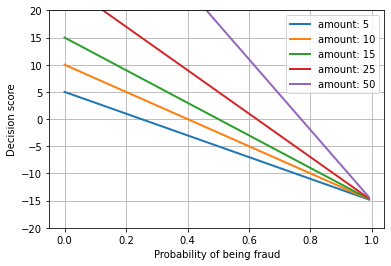

In [28]:
ax = plt.subplot(111)
fraud_fee = 15.0
amounts = [5, 10, 15, 25, 50]
for amount in amounts:
    p = np.arange(0.0, 1.0, 0.01)
    potential_profit = amount*(1-p) - p*fraud_fee
    line, = plt.plot(p, potential_profit, lw=2,label="amount: {}".format(amount))
plt.grid(True)
plt.legend()
ax.set_ylabel("Decision score")
ax.set_xlabel("Probability of being fraud")
plt.ylim(-20, 20)
plt.show()


In [11]:
# optimal decision method
def optimal_decision(amount, fraud_fee, p):
    """Computes the optimal decision between blocking or not blocking of the transaction
        Parameters
        ----------
        amount : amount of the transaction
        fraud_fee : fraud fee
        p : probability of the transaction to be a fraud
        Returns
        -------
        decision : boolean :
                    True if the transaction must be blocked
                    False if the transaction must not be blocked
        """
    potential_profit  = amount*(1-p) - p*fraud_fee
    return potential_profit < 0



